# Chapter 5: Multi-Dataset Relationships

**Purpose:** Combine multiple explored datasets, define relationships, and plan feature aggregations before feature engineering.

**When to use this notebook:**
- You have explored multiple datasets using notebooks 01-04 (or 01a-01d)
- Your datasets share common keys (e.g., customer_id)
- You want to create features from event-level data to join with entity-level data

**What you'll learn:**
- How to discover and manage multiple exploration findings
- How to detect and define relationships between datasets
- How to plan time-window aggregations for event datasets
- How to preview the feature set before engineering

**Outputs:**
- Multi-dataset findings file (YAML)
- Relationship definitions
- Aggregation plan

---

## Multi-Dataset Architecture

```
+------------------+      +-------------------+      +------------------+
|  Entity Dataset  |      |  Event Dataset 1  |      |  Event Dataset 2 |
|  (customers.csv) |      | (transactions.csv)|      |   (emails.csv)   |
|                  |      |                   |      |                  |
| - customer_id    |<---->| - customer_id     |<---->| - customer_id    |
| - churned (Y)    |      | - transaction_date|      | - sent_date      |
| - city           |      | - amount          |      | - opened         |
+------------------+      +-------------------+      +------------------+
         |                         |                         |
         v                         v                         v
   Primary Table           Aggregate to:              Aggregate to:
   (one row per           - amount_sum_7d            - email_count_30d
    customer)             - txn_count_30d            - open_rate_90d
```

## 5.1 Setup and Discover Datasets

In [1]:
from customer_retention.analysis.auto_explorer import (
    ExplorationManager,
    MultiDatasetFindings,
    ExplorationFindings,
    RecommendationRegistry,
)
from customer_retention.stages.profiling import (
    RelationshipDetector,
    TimeWindowAggregator,
    RelationshipType,
    SegmentAnalyzer,
    SegmentationMethod,
    FeatureCapacityAnalyzer,
    TemporalFeatureEngineer,
    TemporalAggregationConfig,
    ReferenceMode,
    FeatureGroup,
    DimensionReductionMethod,
)
from customer_retention.analysis.visualization import ChartBuilder, display_figure, display_table
from customer_retention.core.config.column_config import DatasetGranularity, ColumnType
from pathlib import Path
import yaml
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from customer_retention.core.config.experiments import FINDINGS_DIR, EXPERIMENTS_DIR, OUTPUT_DIR, setup_experiments_structure


In [2]:
# === CONFIGURATION ===
# FINDINGS_DIR imported from customer_retention.core.config.experiments

# Initialize the exploration manager
manager = ExplorationManager(explorations_dir=FINDINGS_DIR)

# Discover all explored datasets (prefers aggregated over event-level when both exist)
findings_files = manager.discover_findings(prefer_aggregated=True)
skipped_files = manager.get_skipped_event_findings()

print(f"Found {len(findings_files)} explored dataset(s):\n")
for f in findings_files:
    print(f"  - {f.name}")

if skipped_files:
    print(f"\n⏭️ Skipped {len(skipped_files)} event-level findings (using aggregated versions instead):")
    for f in skipped_files:
        print(f"  - {f.name}")

# Load or initialize recommendations registry
RECOMMENDATIONS_PATH = FINDINGS_DIR / "recommendations.yaml"
if RECOMMENDATIONS_PATH.exists():
    with open(RECOMMENDATIONS_PATH, "r") as f:
        registry = RecommendationRegistry.from_dict(yaml.safe_load(f))
    print(f"\nLoaded existing recommendations: {len(registry.all_recommendations)} total")
else:
    registry = RecommendationRegistry()
    print("\nInitialized new recommendation registry")

Found 1 explored dataset(s):

  - customer_emails_408768_aggregated_846212_findings.yaml

⏭️ Skipped 1 event-level findings (using aggregated versions instead):
  - customer_emails_408768_findings.yaml

Loaded existing recommendations: 0 total


In [3]:
# List datasets with details
datasets = manager.list_datasets()

print("\n" + "="*70)
print("DISCOVERED DATASETS")
print("="*70 + "\n")

for ds in datasets:
    granularity_emoji = "\U0001f4ca" if ds.granularity == DatasetGranularity.ENTITY_LEVEL else "\U0001f4c8"
    target_info = f" [TARGET: {ds.target_column}]" if ds.target_column else ""
    
    print(f"{granularity_emoji} {ds.name}")
    print(f"   Granularity: {ds.granularity.value}")
    print(f"   Rows: {ds.row_count:,} | Columns: {ds.column_count}")
    if ds.entity_column:
        print(f"   Entity: {ds.entity_column} | Time: {ds.time_column}")
    print(f"   Source: {ds.source_path}{target_info}")
    print()


DISCOVERED DATASETS

📊 customer_emails_aggregated
   Granularity: entity_level
   Rows: 4,998 | Columns: 72
   Source: /Users/Vital/python/CustomerRetention/experiments/findings/customer_emails_408768_aggregated.parquet [TARGET: target]



## 5.2 Multi-Dataset Dashboard

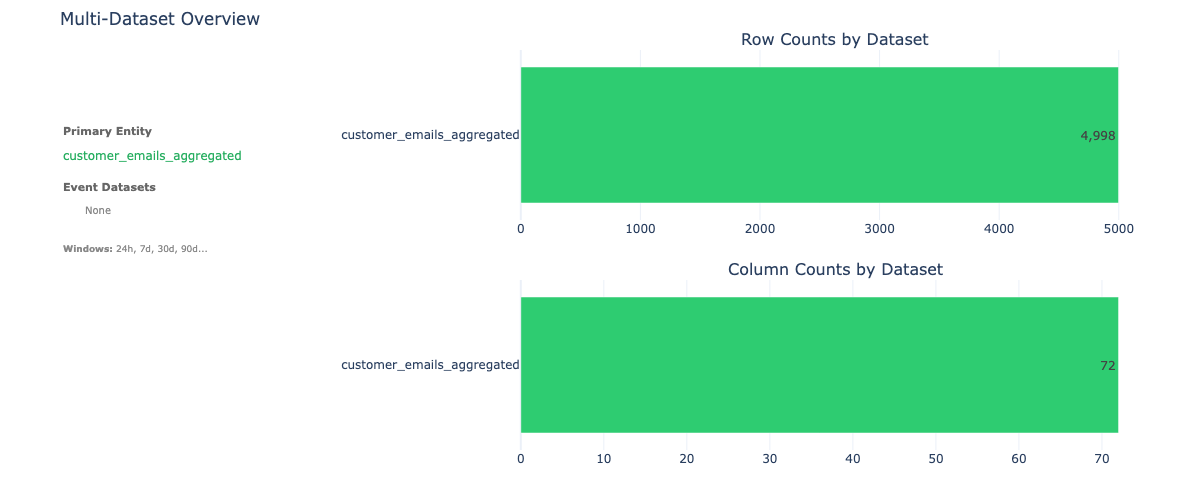

Legend: 🟢 Entity-level (one row per entity)  🔵 Event-level (multiple rows per entity)


In [4]:
# Create multi-dataset findings and visual dashboard
multi = manager.create_multi_dataset_findings()

if len(datasets) > 0:
    # Prepare data for visualization
    names = [ds.name for ds in datasets]
    rows = [ds.row_count for ds in datasets]
    cols = [ds.column_count for ds in datasets]
    granularities = ["Entity" if ds.granularity == DatasetGranularity.ENTITY_LEVEL else "Event" 
                     for ds in datasets]
    colors = ["#2ecc71" if ds.granularity == DatasetGranularity.ENTITY_LEVEL else "#3498db"
              for ds in datasets]

    # Create dashboard with metrics column + horizontal bar charts
    fig = make_subplots(
        rows=2, cols=2,
        column_widths=[0.35, 0.65],
        row_heights=[0.5, 0.5],
        specs=[[{"type": "xy", "rowspan": 2}, {"type": "bar"}],
               [None, {"type": "bar"}]],
        subplot_titles=("", "Row Counts by Dataset", "Column Counts by Dataset"),
        horizontal_spacing=0.12,
        vertical_spacing=0.15
    )

    # Left panel: invisible placeholder for metrics
    fig.add_trace(go.Scatter(x=[0], y=[0], mode='markers', marker=dict(opacity=0), showlegend=False), row=1, col=1)

    # Top right: Horizontal bar chart for row counts (names readable on y-axis)
    fig.add_trace(
        go.Bar(y=names, x=rows, orientation='h', marker_color=colors, name="Rows",
               text=[f"{r:,}" for r in rows], textposition="auto",
               hovertemplate="%{y}: %{x:,} rows<extra></extra>"),
        row=1, col=2
    )

    # Bottom right: Horizontal bar chart for column counts
    fig.add_trace(
        go.Bar(y=names, x=cols, orientation='h', marker_color=colors, name="Columns",
               text=cols, textposition="auto",
               hovertemplate="%{y}: %{x} columns<extra></extra>"),
        row=2, col=2
    )

    # Build metrics text for left panel (expandable list format)
    annotations = []
    y_pos = 0.98

    # Total Datasets (label + value)
    annotations.append(dict(x=0.01, y=y_pos, xref="paper", yref="paper",
        text="<b>Total Datasets</b>", showarrow=False, font=dict(size=11, color="#666"), xanchor="left"))
    y_pos -= 0.06
    annotations.append(dict(x=0.01, y=y_pos, xref="paper", yref="paper",
        text=f"<b>{len(multi.datasets)}</b>", showarrow=False, font=dict(size=18, color="#2c3e50"), xanchor="left"))
    y_pos -= 0.10

    # Primary Entity Dataset
    primary_name = multi.primary_entity_dataset or "Not detected"
    primary_color = "#27ae60" if multi.primary_entity_dataset else "#e74c3c"
    annotations.append(dict(x=0.01, y=y_pos, xref="paper", yref="paper",
        text="<b>Primary Entity</b>", showarrow=False, font=dict(size=11, color="#666"), xanchor="left"))
    y_pos -= 0.06
    annotations.append(dict(x=0.01, y=y_pos, xref="paper", yref="paper",
        text=f"<span style='color:{primary_color}'>{primary_name}</span>", 
        showarrow=False, font=dict(size=12), xanchor="left"))
    y_pos -= 0.10

    # Event Datasets (expandable list - one per row)
    annotations.append(dict(x=0.01, y=y_pos, xref="paper", yref="paper",
        text="<b>Event Datasets</b>", showarrow=False, font=dict(size=11, color="#666"), xanchor="left"))
    y_pos -= 0.06
    
    if multi.event_datasets:
        # Show each event dataset on its own line (supports 20+ datasets)
        max_display = min(len(multi.event_datasets), 8)  # Show up to 8, then summarize
        for i, event_name in enumerate(multi.event_datasets[:max_display]):
            annotations.append(dict(x=0.03, y=y_pos, xref="paper", yref="paper",
                text=f"• {event_name}", showarrow=False, font=dict(size=10, color="#3498db"), xanchor="left"))
            y_pos -= 0.045
        
        if len(multi.event_datasets) > max_display:
            remaining = len(multi.event_datasets) - max_display
            annotations.append(dict(x=0.03, y=y_pos, xref="paper", yref="paper",
                text=f"... +{remaining} more", showarrow=False, font=dict(size=10, color="#888"), xanchor="left"))
            y_pos -= 0.045
    else:
        annotations.append(dict(x=0.03, y=y_pos, xref="paper", yref="paper",
            text="None", showarrow=False, font=dict(size=10, color="#888"), xanchor="left"))
        y_pos -= 0.045

    # Aggregation Windows at bottom
    y_pos = max(y_pos - 0.05, 0.02)
    windows_str = ", ".join(multi.aggregation_windows[:4])
    if len(multi.aggregation_windows) > 4:
        windows_str += "..."
    annotations.append(dict(x=0.01, y=y_pos, xref="paper", yref="paper",
        text=f"<b>Windows:</b> {windows_str}", showarrow=False, font=dict(size=9, color="#888"), xanchor="left"))

    fig.update_layout(
        title="Multi-Dataset Overview",
        height=500,
        showlegend=False,
        template="plotly_white",
        annotations=annotations
    )

    # Hide axes on left panel
    fig.update_xaxes(visible=False, row=1, col=1)
    fig.update_yaxes(visible=False, row=1, col=1)
    
    # Configure horizontal bar axes
    fig.update_yaxes(categoryorder='total ascending', row=1, col=2)
    fig.update_yaxes(categoryorder='total ascending', row=2, col=2)

    display_figure(fig)

    # Legend for colors
    print("Legend: 🟢 Entity-level (one row per entity)  🔵 Event-level (multiple rows per entity)")
else:
    print("No datasets found. Run notebooks 01a-01d first to explore your data.")

## 5.3 Dataset Selection (Optional Override)

By default, all discovered datasets are included. To analyze only specific datasets, provide their names below.

In [5]:
# === DATASET SELECTION (Optional) ===
# Set to None to use all discovered datasets (default)
# Or provide a list of dataset names to include only those
DATASET_NAMES = ['customer_retention_retail']  # e.g., ["customers", "transactions", "emails"]

if DATASET_NAMES:
    # Filter to only specified datasets
    available_names = [ds.name for ds in datasets]
    valid_names = [name for name in DATASET_NAMES if name in available_names]
    invalid_names = [name for name in DATASET_NAMES if name not in available_names]

    if invalid_names:
        print(f"⚠️ Datasets not found: {invalid_names}")
        print(f"   Available: {available_names}")

    if valid_names:
        # Recreate multi-dataset findings with only selected datasets
        multi = manager.create_multi_dataset_findings(dataset_names=valid_names)
        print(f"✓ Using {len(valid_names)} selected dataset(s): {valid_names}")
    else:
        print("⚠️ No valid datasets specified. Using all discovered datasets.")
else:
    print(f"Using all {len(datasets)} discovered dataset(s)")

⚠️ Datasets not found: ['customer_retention_retail']
   Available: ['customer_emails_aggregated']
⚠️ No valid datasets specified. Using all discovered datasets.


## 5.4 Define Relationships Between Datasets

Relationships define how datasets connect. For each event dataset, specify:
- Which entity dataset it relates to
- Which columns form the join key
- The relationship type (one-to-many for event data)

In [6]:
# Try to auto-detect relationships using sample data
print("\n" + "="*70)
print("RELATIONSHIP DETECTION")
print("="*70 + "\n")

detector = RelationshipDetector()

# If we have a primary entity dataset and event datasets, try to detect relationships
if multi.primary_entity_dataset and multi.event_datasets:
    primary_info = multi.datasets[multi.primary_entity_dataset]
    
    print(f"Primary dataset: {multi.primary_entity_dataset}")
    print(f"Checking relationships with event datasets...\n")
    
    for event_name in multi.event_datasets:
        event_info = multi.datasets[event_name]
        
        # Check if they share common column names
        if event_info.entity_column:
            print(f"\U0001f517 {multi.primary_entity_dataset} <-> {event_name}")
            print(f"   Potential join column: {event_info.entity_column}")
            print(f"   Expected relationship: one_to_many")
            print()
else:
    print("Not enough datasets to detect relationships.")
    print("Need at least one entity-level and one event-level dataset.")


RELATIONSHIP DETECTION

Not enough datasets to detect relationships.
Need at least one entity-level and one event-level dataset.


In [7]:
# === MANUAL RELATIONSHIP DEFINITION ===
# Define relationships between your datasets
# Uncomment and modify as needed

# Example: Link transactions to customers
# multi.add_relationship(
#     left_dataset="customers",
#     right_dataset="transactions",
#     left_column="customer_id",
#     right_column="customer_id",
#     relationship_type="one_to_many"
# )

# Example: Link emails to customers
# multi.add_relationship(
#     left_dataset="customers",
#     right_dataset="emails",
#     left_column="customer_id",
#     right_column="customer_id",
#     relationship_type="one_to_many"
# )

print(f"Defined relationships: {len(multi.relationships)}")
for rel in multi.relationships:
    print(f"   {rel.left_dataset}.{rel.left_column} -> {rel.right_dataset}.{rel.right_column} ({rel.relationship_type})")

# Initialize silver layer if not already done
if registry.silver is None:
    entity_col = multi.datasets[multi.primary_entity_dataset].entity_column if multi.primary_entity_dataset else "entity_id"
    registry.init_silver(entity_col)

# Persist join recommendations to registry
for rel in multi.relationships:
    registry.add_silver_join(
        left_source=rel.left_dataset,
        right_source=rel.right_dataset,
        join_keys=[rel.left_column],
        join_type=rel.relationship_type,
        rationale=f"Join {rel.left_dataset} with {rel.right_dataset} on {rel.left_column}",
        source_notebook="05_multi_dataset"
    )

if multi.relationships:
    print(f"\n✅ Persisted {len(multi.relationships)} join recommendations to registry")

Defined relationships: 0


## 5.5 Plan Temporal Feature Engineering

For event datasets, we engineer sophisticated temporal features using **per-customer alignment**:
- Each customer's features are computed relative to their reference date (churn date or last activity)
- This makes historical churners comparable to current active customers

**Feature Groups Available:**

| Group | Features | Purpose |
|-------|----------|---------|
| **Lagged Windows** | `lag0_{metric}_{agg}`, `lag1_{metric}_{agg}`, ... | Sequential non-overlapping time windows |
| **Velocity** | `{metric}_velocity`, `{metric}_velocity_pct` | Rate of change between windows |
| **Acceleration** | `{metric}_acceleration`, `{metric}_momentum` | Change in velocity, weighted direction |
| **Lifecycle** | `{metric}_beginning`, `{metric}_middle`, `{metric}_end` | Beginning/middle/end of customer history |
| **Recency** | `days_since_last_event`, `active_span_days` | How recently customer was active |
| **Regularity** | `event_frequency`, `regularity_score` | Consistency of engagement |
| **Cohort Comparison** | `{metric}_cohort_zscore` | Customer vs peer group |

In [8]:
# Get aggregation plan for event datasets
agg_plan = multi.get_aggregation_plan()

print("\n" + "="*70)
print("AGGREGATION PLAN")
print("="*70 + "\n")

if agg_plan:
    for dataset_name, plan in agg_plan.items():
        print(f"\U0001f4ca {dataset_name}")
        print(f"   Entity column: {plan.entity_column}")
        print(f"   Time column: {plan.time_column}")
        print(f"   Windows: {plan.windows}")
        print(f"   Default agg funcs: {plan.agg_funcs}")
        print()
else:
    print("No event datasets to aggregate.")

# Show available feature groups
print("\n" + "="*70)
print("TEMPORAL FEATURE GROUPS")
print("="*70 + "\n")

for group in FeatureGroup:
    enabled = "✓" if group in [FeatureGroup.LAGGED_WINDOWS, FeatureGroup.VELOCITY, 
                               FeatureGroup.RECENCY, FeatureGroup.REGULARITY] else "○"
    print(f"  {enabled} {group.value}")


AGGREGATION PLAN

No event datasets to aggregate.

TEMPORAL FEATURE GROUPS

  ✓ lagged_windows
  ✓ velocity
  ○ acceleration
  ○ lifecycle
  ✓ recency
  ✓ regularity
  ○ cohort_comparison


In [9]:
# === CONFIGURE TEMPORAL FEATURES ===

# Reference mode: PER_CUSTOMER aligns to each customer's reference date
# This is critical for churn models where customers churned at different times
REFERENCE_MODE = ReferenceMode.PER_CUSTOMER

# Lagged window configuration
LAG_WINDOW_DAYS = 30      # Each lag window spans this many days
NUM_LAGS = 4              # Number of sequential windows (lag0, lag1, lag2, lag3)
LAG_AGGREGATIONS = ["sum", "mean", "count", "max"]  # Aggregations per window

# Feature groups to compute
FEATURE_GROUPS = [
    FeatureGroup.LAGGED_WINDOWS,   # lag0_amount_sum, lag1_amount_sum, ...
    FeatureGroup.VELOCITY,          # amount_velocity (rate of change)
    FeatureGroup.ACCELERATION,      # amount_acceleration, amount_momentum
    FeatureGroup.LIFECYCLE,         # amount_beginning, amount_middle, amount_end
    FeatureGroup.RECENCY,           # days_since_last_event, active_span_days
    FeatureGroup.REGULARITY,        # event_frequency, regularity_score
    FeatureGroup.COHORT_COMPARISON, # amount_cohort_zscore
]

# Lifecycle configuration
MIN_HISTORY_DAYS = 60  # Minimum days of history for lifecycle features (else NaN)

# Create configuration
temporal_config = TemporalAggregationConfig(
    reference_mode=REFERENCE_MODE,
    lag_window_days=LAG_WINDOW_DAYS,
    num_lags=NUM_LAGS,
    lag_aggregations=LAG_AGGREGATIONS,
    compute_velocity=FeatureGroup.VELOCITY in FEATURE_GROUPS,
    compute_acceleration=FeatureGroup.ACCELERATION in FEATURE_GROUPS,
    compute_lifecycle=FeatureGroup.LIFECYCLE in FEATURE_GROUPS,
    min_history_days=MIN_HISTORY_DAYS,
    compute_recency=FeatureGroup.RECENCY in FEATURE_GROUPS,
    compute_regularity=FeatureGroup.REGULARITY in FEATURE_GROUPS,
    compute_cohort=FeatureGroup.COHORT_COMPARISON in FEATURE_GROUPS,
)

# Store in multi-dataset findings
multi.notes['temporal_config'] = {
    'reference_mode': REFERENCE_MODE.value,
    'lag_window_days': LAG_WINDOW_DAYS,
    'num_lags': NUM_LAGS,
    'lag_aggregations': LAG_AGGREGATIONS,
    'feature_groups': [g.value for g in FEATURE_GROUPS],
    'min_history_days': MIN_HISTORY_DAYS,
}

# Persist temporal configuration to registry for each event dataset
for dataset_name in multi.event_datasets:
    ds_info = multi.datasets[dataset_name]
    findings = manager.load_findings(dataset_name)
    
    if findings:
        numeric_cols = [
            name for name, col in findings.columns.items()
            if col.inferred_type in [ColumnType.NUMERIC_CONTINUOUS, ColumnType.NUMERIC_DISCRETE]
            and name not in [ds_info.entity_column, ds_info.time_column] and name not in TEMPORAL_METADATA_COLS
        ]
        
        if numeric_cols:
            registry.add_silver_temporal_config(
                source_dataset=dataset_name,
                columns=numeric_cols,
                lag_windows=NUM_LAGS,
                lag_window_days=LAG_WINDOW_DAYS,
                aggregations=LAG_AGGREGATIONS,
                feature_groups=[g.value for g in FEATURE_GROUPS],
                rationale=f"Temporal features for {dataset_name} with {len(numeric_cols)} columns",
                source_notebook="05_multi_dataset"
            )

print("Temporal Feature Configuration:")
print(f"   Reference Mode: {REFERENCE_MODE.value}")
print(f"   Lag Windows: {NUM_LAGS} x {LAG_WINDOW_DAYS} days")
print(f"   Aggregations: {LAG_AGGREGATIONS}")
print(f"   Feature Groups: {len(FEATURE_GROUPS)} enabled")
print()
print("\U0001f4a1 With per-customer alignment, all customers are measured from their reference point.")
print("   - Churned customers: reference = churn date")
print("   - Active customers: reference = last activity or analysis date")

if multi.event_datasets:
    print(f"\n✅ Persisted temporal config for {len(multi.event_datasets)} event dataset(s)")

Temporal Feature Configuration:
   Reference Mode: per_customer
   Lag Windows: 4 x 30 days
   Aggregations: ['sum', 'mean', 'count', 'max']
   Feature Groups: 7 enabled

💡 With per-customer alignment, all customers are measured from their reference point.
   - Churned customers: reference = churn date
   - Active customers: reference = last activity or analysis date


## 5.6 Preview Feature Set

Preview the features that will be created from time-window aggregations.

In [10]:
# For each event dataset, preview what features could be created
print("\n" + "="*70)
print("TEMPORAL FEATURES PREVIEW")
print("="*70 + "\n")

for dataset_name in multi.event_datasets:
    ds_info = multi.datasets[dataset_name]
    
    print(f"\U0001f4c8 From {dataset_name}:")
    print()
    
    # Load findings to see numeric columns
    findings = manager.load_findings(dataset_name)
    
    # Find numeric columns that could be aggregated
    numeric_cols = []
    if findings:
        numeric_cols = [
            name for name, col in findings.columns.items()
            if col.inferred_type in [ColumnType.NUMERIC_CONTINUOUS, ColumnType.NUMERIC_DISCRETE]
            and name not in [ds_info.entity_column, ds_info.time_column] and name not in TEMPORAL_METADATA_COLS
        ]
    
    # Group 1: Lagged Window Features
    if FeatureGroup.LAGGED_WINDOWS in FEATURE_GROUPS:
        print("   📊 LAGGED WINDOWS (Group 1):")
        for col in numeric_cols[:2]:
            features = [f"lag{i}_{col}_{agg}" for i in range(NUM_LAGS) for agg in LAG_AGGREGATIONS[:2]]
            print(f"      {col}: {features[:4]}...")
        print(f"      Total: {len(numeric_cols)} cols × {NUM_LAGS} lags × {len(LAG_AGGREGATIONS)} aggs")
    
    # Group 2: Velocity Features
    if FeatureGroup.VELOCITY in FEATURE_GROUPS:
        print("\n   🚀 VELOCITY (Group 2):")
        for col in numeric_cols[:2]:
            print(f"      - {col}_velocity, {col}_velocity_pct")
        print(f"      Total: {len(numeric_cols)} cols × 2 features")
    
    # Group 3: Acceleration Features
    if FeatureGroup.ACCELERATION in FEATURE_GROUPS:
        print("\n   ⚡ ACCELERATION (Group 3):")
        for col in numeric_cols[:2]:
            print(f"      - {col}_acceleration, {col}_momentum")
        print(f"      Total: {len(numeric_cols)} cols × 2 features")
    
    # Group 4: Lifecycle Features
    if FeatureGroup.LIFECYCLE in FEATURE_GROUPS:
        print("\n   📈 LIFECYCLE (Group 4):")
        for col in numeric_cols[:2]:
            print(f"      - {col}_beginning, {col}_middle, {col}_end, {col}_trend_ratio")
        print(f"      Total: {len(numeric_cols)} cols × 4 features")
        print(f"      ℹ️ Requires {MIN_HISTORY_DAYS}+ days of history (else NaN)")
    
    # Group 5: Recency Features
    if FeatureGroup.RECENCY in FEATURE_GROUPS:
        print("\n   ⏱️ RECENCY (Group 5):")
        print("      - days_since_last_event")
        print("      - days_since_first_event")
        print("      - active_span_days")
        print("      - recency_ratio")
    
    # Group 6: Regularity Features
    if FeatureGroup.REGULARITY in FEATURE_GROUPS:
        print("\n   🎯 REGULARITY (Group 6):")
        print("      - event_frequency")
        print("      - inter_event_gap_mean")
        print("      - inter_event_gap_std")
        print("      - regularity_score")
    
    # Group 7: Cohort Comparison
    if FeatureGroup.COHORT_COMPARISON in FEATURE_GROUPS:
        print("\n   👥 COHORT COMPARISON (Group 7):")
        for col in numeric_cols[:2]:
            print(f"      - {col}_vs_cohort_mean, {col}_vs_cohort_pct, {col}_cohort_zscore")
        print(f"      Total: {len(numeric_cols)} cols × 3 features")
    
    # Summary
    total_features = 0
    if FeatureGroup.LAGGED_WINDOWS in FEATURE_GROUPS:
        total_features += len(numeric_cols) * NUM_LAGS * len(LAG_AGGREGATIONS)
    if FeatureGroup.VELOCITY in FEATURE_GROUPS:
        total_features += len(numeric_cols) * 2
    if FeatureGroup.ACCELERATION in FEATURE_GROUPS:
        total_features += len(numeric_cols) * 2
    if FeatureGroup.LIFECYCLE in FEATURE_GROUPS:
        total_features += len(numeric_cols) * 4
    if FeatureGroup.RECENCY in FEATURE_GROUPS:
        total_features += 4
    if FeatureGroup.REGULARITY in FEATURE_GROUPS:
        total_features += 4
    if FeatureGroup.COHORT_COMPARISON in FEATURE_GROUPS:
        total_features += len(numeric_cols) * 3
    
    print(f"\n   📝 TOTAL ESTIMATED FEATURES: ~{total_features}")
    print()


TEMPORAL FEATURES PREVIEW



## 5.7 Segmentation Analysis

Should we build **separate models per customer segment** or a **single unified model**? This analysis provides evidence-based metrics to make that decision.

**Key Decision Metrics:**

| Metric | What It Measures | Good Value |
|--------|------------------|------------|
| **Silhouette Score** | Cluster cohesion (how tight) & separation (how different) | > 0.25 |
| **Target Variance** | How much target rates differ across segments | > 0.15 |
| **Segment Balance** | Size distribution across segments | > 0.3 ratio |
| **EPV per Segment** | Events-per-variable for reliable modeling | > 10 |

**Interpretation Guide:**
- **Silhouette > 0.5**: Strong natural clustering - segments are distinct
- **Silhouette 0.25-0.5**: Reasonable structure - segments somewhat distinct  
- **Silhouette < 0.25**: Weak structure - data is relatively homogeneous
- **Silhouette < 0**: Overlapping clusters - segmentation not supported

In [11]:
# Segmentation Analysis on Primary Entity Dataset
from customer_retention.stages.temporal import load_data_with_snapshot_preference

print("=" * 70)
print("SEGMENTATION ANALYSIS")
print("=" * 70)

segment_analyzer = SegmentAnalyzer()
capacity_analyzer = FeatureCapacityAnalyzer()

# Consistent color palette: Segment 0=blue, 1=red, 2=green, 3=purple, etc.
SEGMENT_COLORS = {
    0: '#3498db',  # Blue
    1: '#e74c3c',  # Red
    2: '#2ecc71',  # Green
    3: '#9b59b6',  # Purple
    4: '#f39c12',  # Orange
    5: '#1abc9c',  # Teal
    6: '#e67e22',  # Dark Orange
}

if multi.primary_entity_dataset:
    primary_info = multi.datasets[multi.primary_entity_dataset]
    primary_findings = manager.load_findings(multi.primary_entity_dataset)
    
    if primary_findings:
        # Load the primary dataset from snapshot (not source) to get correct column names
        primary_df, data_source = load_data_with_snapshot_preference(primary_findings, output_dir=str(FINDINGS_DIR))
        print(f"   Loaded from: {data_source}")
        
        # Get numeric features for clustering (exclude temporal metadata)
        from customer_retention.stages.temporal import TEMPORAL_METADATA_COLS
        numeric_features = [
            name for name, col in primary_findings.columns.items()
            if col.inferred_type in [ColumnType.NUMERIC_CONTINUOUS, ColumnType.NUMERIC_DISCRETE]
            and name != primary_info.target_column
            and name not in TEMPORAL_METADATA_COLS
        ]
        
        print(f"\n📊 Dataset: {multi.primary_entity_dataset}")
        print(f"   Total Samples: {len(primary_df):,}")
        print(f"   Numeric Features: {len(numeric_features)}")
        print(f"   Target Column: {primary_info.target_column}")
        
        # Run full segmentation analysis using framework
        analysis = segment_analyzer.run_full_analysis(
            primary_df,
            feature_cols=numeric_features,
            target_col=primary_info.target_column,
            max_segments=5,
            dim_reduction=DimensionReductionMethod.PCA,
        )
        m = analysis.metrics  # Shorthand for metrics
        
        # ============================================================
        # KEY DECISION METRICS
        # ============================================================
        print("\n" + "=" * 70)
        print("📊 CLUSTERING DECISION METRICS")
        print("=" * 70)
        
        print(f"""
┌─────────────────────────────────────────────────────────────────────┐
│  METRIC                          │  VALUE      │  INTERPRETATION    │
├──────────────────────────────────┼─────────────┼────────────────────┤
│  Silhouette Score (cohesion)     │  {m.silhouette_score:+.3f}      │  {m.silhouette_interpretation:<18} │
│  Target Rate Variance            │  {f'{m.target_variance_ratio:.3f}' if m.target_variance_ratio else 'N/A':>11} │  {m.target_variance_interpretation:<18} │
│  Optimal Segments Found          │  {m.n_segments}           │  {m.segments_interpretation:<18} │
│  Overall Confidence              │  {m.confidence:.0%}         │  {m.confidence_interpretation:<18} │
└──────────────────────────────────┴─────────────┴────────────────────┘""")
        
        print(f"\n🎯 RECOMMENDATION: {m.recommendation.upper().replace('_', ' ')}")
        print(f"\n📋 Supporting Evidence:")
        for r in m.rationale:
            print(f"   • {r}")
        
        # ============================================================
        # SEGMENT PROFILES
        # ============================================================
        print("\n" + "=" * 70)
        print("📊 SEGMENT PROFILES")
        print("=" * 70 + "\n")
        
        segment_data = [{
            "Segment": f"Segment {p.segment_id}",
            "N (count)": f"{p.size:,}",
            "% of Total": f"{p.size_pct:.1f}%",
            "Target Rate": f"{p.target_rate:.1%}" if p.target_rate is not None else "N/A",
            "Viable for ML": "✓" if p.size >= 100 else "⚠️"
        } for p in analysis.profiles]
        display(pd.DataFrame(segment_data))
        
        sd = analysis.size_distribution
        print(f"\n📊 Size Distribution:")
        print(f"   Total datapoints: {sd['total']:,}")
        print(f"   Smallest segment: {sd['min_size']:,} ({sd['min_pct']:.1f}%)")
        print(f"   Largest segment: {sd['max_size']:,} ({sd['max_pct']:.1f}%)")
        print(f"   Balance ratio: {sd['balance_ratio']:.2f} (1.0 = perfectly balanced)")
        
        # ============================================================
        # CLUSTER VISUALIZATION
        # ============================================================
        if analysis.has_visualization:
            viz = analysis.visualization
            seg_result = analysis.segmentation_result
            
            fig = make_subplots(
                rows=1, cols=3,
                subplot_titles=(
                    f"Cluster Visualization (PCA, {viz.explained_variance_ratio:.0%} var)" 
                    if viz.explained_variance_ratio else "Cluster Visualization (PCA)",
                    "Segment Sizes", "Target Rate"
                ),
                horizontal_spacing=0.12,
                column_widths=[0.4, 0.3, 0.3]
            )
            
            unique_labels = sorted(set(seg_result.labels[seg_result.labels >= 0]))
            
            # Scatter plot - consistent colors by segment ID
            for label in unique_labels:
                mask = seg_result.labels == label
                color = SEGMENT_COLORS.get(label, '#888888')
                profile = next((p for p in analysis.profiles if p.segment_id == label), None)
                name = f"Seg {label} (n={profile.size:,})" if profile else f"Seg {label}"
                fig.add_trace(go.Scatter(
                    x=viz.x[mask], y=viz.y[mask], mode='markers',
                    marker=dict(color=color, size=6, opacity=0.6),
                    name=name, hovertemplate=f"{name}<br>PC1: %{{x:.2f}}<br>PC2: %{{y:.2f}}<extra></extra>"
                ), row=1, col=1)
            
            # Short labels for bar charts (avoid overlap)
            bar_labels = [f"Seg {p.segment_id}" for p in analysis.profiles]
            sizes = [p.size for p in analysis.profiles]
            bar_colors = [SEGMENT_COLORS.get(p.segment_id, '#888888') for p in analysis.profiles]
            
            # Size bars - numbers inside
            fig.add_trace(go.Bar(
                y=bar_labels, x=sizes, orientation='h',
                marker_color=bar_colors,
                text=[f"{s:,}" for s in sizes],
                textposition='inside', textfont=dict(color='white'),
                showlegend=False,
                hovertemplate="Segment %{y}<br>Count: %{x:,}<extra></extra>"
            ), row=1, col=2)
            
            # Target rates - consistent segment colors, numbers inside
            if all(p.target_rate is not None for p in analysis.profiles):
                rates = [p.target_rate * 100 for p in analysis.profiles]
                fig.add_trace(go.Bar(
                    y=bar_labels, x=rates, orientation='h',
                    marker_color=bar_colors,  # Same colors as size chart
                    text=[f"{r:.1f}%" for r in rates],
                    textposition='inside', textfont=dict(color='white'),
                    showlegend=False,
                    hovertemplate="Segment %{y}<br>Target: %{x:.1f}%<extra></extra>"
                ), row=1, col=3)
                overall = sum(p.target_rate * p.size for p in analysis.profiles) / sd['total'] * 100
                fig.add_vline(x=overall, line_dash="dash", line_color="#2c3e50",
                             annotation_text=f"Avg: {overall:.1f}%", annotation_position="top", row=1, col=3)
            
            fig.update_layout(
                title="Segment Analysis Overview", 
                height=400, 
                template="plotly_white",
                legend=dict(
                    orientation="h", 
                    yanchor="top", 
                    y=-0.15,
                    xanchor="center", 
                    x=0.5
                ),
                margin=dict(r=20, b=80)
            )
            fig.update_xaxes(title_text="PC1", row=1, col=1)
            fig.update_yaxes(title_text="PC2", row=1, col=1)
            display_figure(fig)
            
            print(f"\n📈 CLUSTER VISUALIZATION:")
            print(f"   Method: PCA | Variance Explained: {viz.explained_variance_ratio:.1%}" if viz.explained_variance_ratio else "   Method: PCA")
            print(f"   Colors: Seg 0=Blue, Seg 1=Red, Seg 2=Green, Seg 3=Purple")
        
        # ============================================================
        # EPV CAPACITY ANALYSIS
        # ============================================================
        if m.n_segments > 1 and primary_info.target_column:
            print("\n" + "=" * 70)
            print("💡 SEGMENT CAPACITY ANALYSIS (EPV Check)")
            print("=" * 70)
            
            primary_df['_segment'] = analysis.segmentation_result.labels
            capacity = capacity_analyzer.analyze_segment_capacity(
                primary_df[primary_df['_segment'] >= 0],
                feature_cols=numeric_features,
                target_col=primary_info.target_column,
                segment_col='_segment'
            )
            primary_df.drop('_segment', axis=1, inplace=True)
            
            print(f"\n🎯 Strategy: {capacity.recommended_strategy.upper()}")
            print(f"   Reason: {capacity.strategy_reason}")
            if capacity.viable_segments:
                print(f"\n   ✅ Viable segments: {capacity.viable_segments}")
            if capacity.insufficient_segments:
                print(f"   ⚠️ Insufficient segments: {capacity.insufficient_segments}")
            
            # Store in findings
            multi.notes.update({
                'segmentation_recommendation': m.recommendation,
                'segmentation_confidence': m.confidence,
                'segmentation_silhouette': m.silhouette_score,
                'segment_count': m.n_segments,
                'segment_strategy': capacity.recommended_strategy,
                'segment_sizes': {f"segment_{p.segment_id}": p.size for p in analysis.profiles}
            })
            
            # Initialize bronze layer if not already done
            if registry.bronze is None:
                registry.init_bronze(primary_info.source_path)
            
            # Persist segmentation strategy to registry
            registry.add_bronze_segmentation_strategy(
                strategy=m.recommendation,
                confidence=m.confidence,
                n_segments=m.n_segments,
                silhouette_score=m.silhouette_score,
                rationale="; ".join(m.rationale[:3]),
                source_notebook="05_multi_dataset"
            )
            print(f"\n✅ Persisted segmentation strategy to registry: {m.recommendation}")
        
        # ============================================================
        # DECISION SUMMARY
        # ============================================================
        print("\n" + "=" * 70)
        print("📋 SEGMENTATION DECISION SUMMARY")
        print("=" * 70)
        print(f"\n{analysis.get_decision_summary()}")

else:
    print("\n⚠️ No primary entity dataset detected.")

SEGMENTATION ANALYSIS


## 5.8 Relationship Diagram

In [12]:
# Create a simple relationship diagram
if len(multi.datasets) > 1:
    print("\n" + "="*70)
    print("DATASET RELATIONSHIP DIAGRAM")
    print("="*70 + "\n")
    
    # ASCII diagram
    if multi.primary_entity_dataset:
        primary = multi.primary_entity_dataset
        primary_info = multi.datasets[primary]
        
        print(f"   +{'='*30}+")
        print(f"   |  {primary:^26}  |  <- PRIMARY (has target)")
        print(f"   |  {primary_info.row_count:,} rows{' '*15}  |")
        if primary_info.target_column:
            print(f"   |  Target: {primary_info.target_column:<17}  |")
        print(f"   +{'='*30}+")
        
        for event_name in multi.event_datasets:
            event_info = multi.datasets[event_name]
            join_col = event_info.entity_column or "?"
            
            print(f"          |")
            print(f"          | {join_col}")
            print(f"          v")
            print(f"   +{'-'*30}+")
            print(f"   |  {event_name:^26}  |  <- EVENT LEVEL")
            print(f"   |  {event_info.row_count:,} rows{' '*15}  |")
            print(f"   |  Time: {event_info.time_column or '?':<19}  |")
            print(f"   +{'-'*30}+")
else:
    print("Single dataset - no relationships to diagram.")

Single dataset - no relationships to diagram.


## 5.9 Save Multi-Dataset Findings

In [13]:
# Save the multi-dataset findings and recommendations registry
MULTI_FINDINGS_PATH = FINDINGS_DIR / "multi_dataset_findings.yaml"

multi.save(str(MULTI_FINDINGS_PATH))

# Save the recommendations registry
with open(RECOMMENDATIONS_PATH, "w") as f:
    yaml.dump(registry.to_dict(), f, default_flow_style=False, sort_keys=False)

print(f"\n✅ Multi-dataset findings saved to: {MULTI_FINDINGS_PATH}")
print(f"\n   Contents:")
print(f"   - {len(multi.datasets)} datasets")
print(f"   - {len(multi.relationships)} relationships")
print(f"   - {len(multi.event_datasets)} event datasets to aggregate")
print(f"   - Aggregation windows: {multi.aggregation_windows}")

print(f"\n✅ Recommendations registry saved: {RECOMMENDATIONS_PATH}")
print(f"   Total recommendations: {len(registry.all_recommendations)}")


✅ Multi-dataset findings saved to: /Users/Vital/python/CustomerRetention/experiments/findings/multi_dataset_findings.yaml

   Contents:
   - 1 datasets
   - 0 relationships
   - 0 event datasets to aggregate
   - Aggregation windows: ['24h', '7d', '30d', '90d', '180d', '365d', 'all_time']

✅ Recommendations registry saved: /Users/Vital/python/CustomerRetention/experiments/findings/recommendations.yaml
   Total recommendations: 0


---

## Summary: What We Learned

In this notebook, we:

1. **Discovered Datasets** - Found all exploration findings from previous notebooks
2. **Visualized Overview** - Dashboard showing dataset sizes and structure
3. **Selected Datasets** - Optionally filtered to specific datasets
4. **Defined Relationships** - Established how datasets connect via keys
5. **Planned Temporal Features** - Configured 7 feature groups (lagged windows, velocity, acceleration, lifecycle, recency, regularity, cohort comparison)
6. **Previewed Features** - Saw what features will be created
7. **Analyzed Segmentation** - Determined if segmented modeling is justified
8. **Saved Configuration** - Saved multi-dataset findings for feature engineering

## Key Decisions Made

| Decision | Value | Rationale |
|----------|-------|-----------|
| Primary Entity Dataset | From `multi.primary_entity_dataset` | Has target column |
| Event Datasets | From `multi.event_datasets` | Event-level data to aggregate |
| Reference Mode | Per-customer alignment | Makes historical churners comparable to active customers |
| Lag Windows | `NUM_LAGS` x `LAG_WINDOW_DAYS` days | Captures recent vs historical patterns |
| Feature Groups | Lagged, Velocity, Acceleration, Lifecycle, Recency, Regularity, Cohort | Comprehensive temporal characterization |
| Segmentation Strategy | From `multi.notes['segment_strategy']` | Based on EPV analysis |

---

## Next Steps

Continue to **06_feature_opportunities.ipynb** to:
- Deep dive into feature engineering opportunities
- Analyze feature capacity constraints
- Create derived features

**Important:** The multi-dataset findings file (`multi_dataset_findings.yaml`) includes temporal feature configuration for use in subsequent notebooks.